In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings 
warnings.filterwarnings('ignore')

import missingno as msno 

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

In [162]:
df_train = pd.read_csv('./titanic/preprocessing.csv')
df_test = pd.read_csv('./titanic/preprocessing_test.csv')
# df_train.drop(['ticket_encode'],axis=1,inplace=True)
# df_test.drop(['ticket_encode'],axis=1,inplace=True)
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0.0,Initial_1.0,Initial_2.0,Initial_3.0,Initial_4.0,Embarked_0,Embarked_1,Embarked_2,ticket_encode
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1,523
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0,596
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1,669
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1,49
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1,472


In [163]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

# 1. 가지고 있는 데이터 중 학습할 데이터와 target label를 분리(여기서 target은 Survived)
X_train = df_train.drop('Survived', axis=1).values
Target_label=df_train['Survived'].values

#트레이닝한 것을 테스트 하기 전 평가하는 단계를 거침
#그래서 테스트를 분리함 train->valid->test용으로
#train_test_split 이용

x_tr,x_vld,y_tr,y_vld = train_test_split(X_train, Target_label,test_size=0.3,random_state=2018)
X_test = df_test.values

In [175]:
# 1 model
from sklearn.ensemble import RandomForestClassifier 
RF_model = RandomForestClassifier()
RF_model.fit(x_tr,y_tr) #fit : 학습
RF_prediction=RF_model.predict(x_vld)

In [176]:
metrics.accuracy_score(RF_prediction,y_vld)

0.8768656716417911

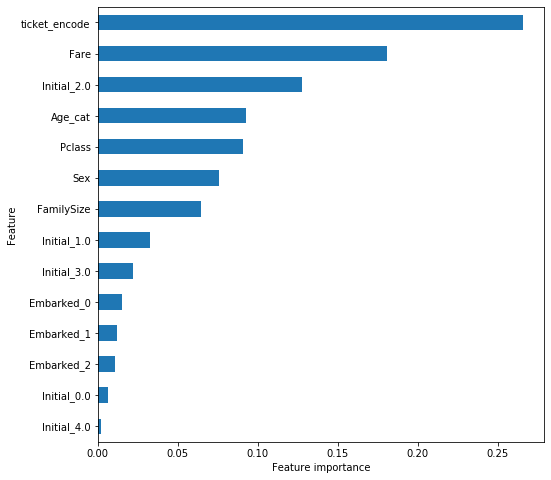

In [177]:
#feature importance
#현재의 모델이 어떤 feature의 영향을 많이 받게 된 것인지 조회
from pandas import Series

#학습한 거에 한번 해봄
feature_importance = RF_model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_train.columns[1::])

plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [178]:
RF_result = RF_model.predict(X_test)

In [179]:
submission = pd.read_csv('./titanic/gender_submission.csv')
submission['RF'] = RF_result
submission.head()

,PassengerId,Survived,RF
0,892,0,0
1,893,1,0
2,894,0,0
3,895,0,0
4,896,1,1


In [180]:
# 2 model
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(x_tr,y_tr)
LR_prediction=LR_model.predict(x_vld)

In [181]:
metrics.accuracy_score(LR_prediction,y_vld)

0.8768656716417911

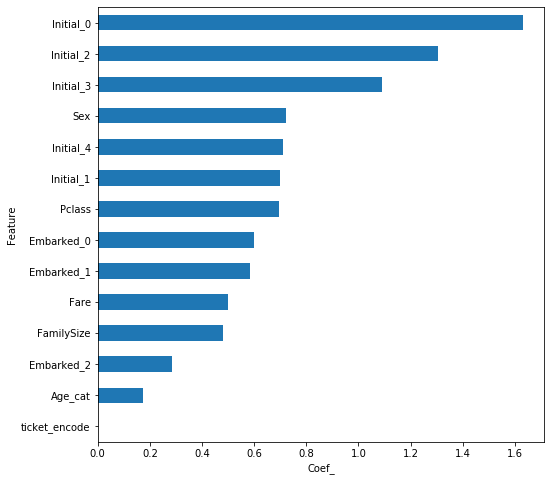

In [182]:
# feature_importance로 비교
'''
logistic은 featre_importance라는 것이 없다.
feature에대한 랭킹을 하는 방법은
coefficiecnt value, recursive feature elimination, selectFromModels 방법이 있다.

'''
# 1)
parameters = abs(LR_model.coef_) 
Series_feat_imp = Series(parameters[0], index=df_test.columns)
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Coef_')
plt.ylabel('Feature')
plt.show()

In [183]:
LR_result=LR_model.predict(X_test)

In [184]:
submission['LR']=LR_result
submission.head()

,PassengerId,Survived,RF,LR
0,892,0,0,0
1,893,1,0,0
2,894,0,0,0
3,895,0,0,0
4,896,1,1,1


In [185]:
# 3 model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
#n_neighbors가 1일때는 정확도 1이었는데 2로 하니 80으로 증가 3은 82 4는 줄음
knn.fit(x_tr,y_tr)
knn_prediction = knn.predict(x_vld)
metrics.accuracy_score(knn_prediction,y_vld)

0.7276119402985075

In [186]:
knn_result=knn.predict(X_test)

In [187]:
submission['knn']=knn_result
submission.head()

,PassengerId,Survived,RF,LR,knn
0,892,0,0,0,1
1,893,1,0,0,1
2,894,0,0,0,0
3,895,0,0,0,0
4,896,1,1,1,0


In [188]:
# 4 model
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                    max_depth=1, random_state=0)
clf.fit(x_tr,y_tr)
#learning_rate에 따라 정확도가 바뀜.
clf_prediction=clf.predict(x_vld)
round(metrics.accuracy_score(clf_prediction,y_vld),2)

0.86

In [189]:
clf_result=clf.predict(X_test)
submission['clf']=clf_result
submission.head()

,PassengerId,Survived,RF,LR,knn,clf
0,892,0,0,0,1,0
1,893,1,0,0,1,1
2,894,0,0,0,0,0
3,895,0,0,0,0,0
4,896,1,1,1,0,1


In [190]:
#정확도 별로 정리
#RF,LR,Knn,clf
data=[round(metrics.accuracy_score(RF_prediction,y_vld),2),
    round(metrics.accuracy_score(LR_prediction,y_vld),2),
    round(metrics.accuracy_score(knn_prediction,y_vld),2),
    round(metrics.accuracy_score(clf_prediction,y_vld),2)]
df_result= pd.read_csv('./titanic/Result.csv')
# df_result['Ticket_LabelEncode'] = data
# df_result.to_csv('./titanic/Result.csv',index=False)

In [199]:
df_result

,Model,Default,Ticket_LabelEncode
0,RF,0.82,0.88
1,LR,0.87,0.88
2,Knn,0.82,0.73
3,CLF,0.86,0.86


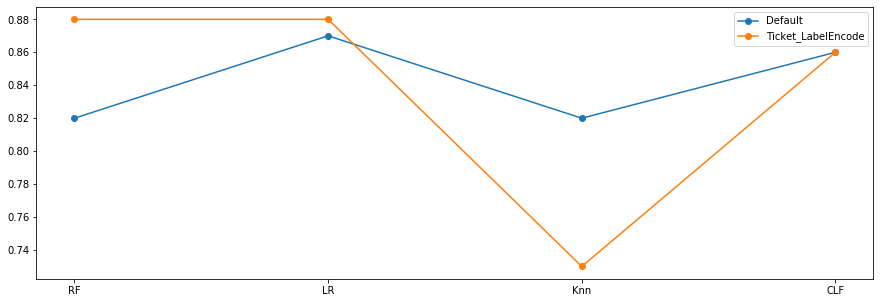

In [214]:
x=df_result['Model']
y_1=df_result['Default']
y_2=df_result['Ticket_LabelEncode']
plt.subplots(figsize=(15,5))
plt.plot(x,y_1,label="Default",marker='o')
plt.plot(x,y_2,label='Ticket_LabelEncode',marker='o')
plt.legend()
plt.show()